In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2022-05-29 10:44:00,984 INFO: generated new fontManager


In [2]:
import hashlib
from datetime import datetime

In [3]:
from hops import hdfs

### We will use rides.csv dataset for testing purposes
It doesn't have any missing data. Shape = (41078, 11).

In [4]:
import hsfs

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


In [2]:
df = pd.read_csv(hdfs.project_path() + "Resources/rides.csv", index_col=0)

NameError: name 'pd' is not defined

In [6]:
df.head(3)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41078 entries, 0 to 41077
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ride_id            41078 non-null  int64  
 1   is_start           41078 non-null  bool   
 2   pickup_datetime    41078 non-null  object 
 3   dropoff_datetime   41078 non-null  int64  
 4   pickup_longitude   41078 non-null  float64
 5   pickup_latitude    41078 non-null  float64
 6   dropoff_longitude  41078 non-null  float64
 7   dropoff_latitude   41078 non-null  float64
 8   passenger_count    41078 non-null  int64  
 9   taxi_id            41078 non-null  int64  
 10  driver_id          41078 non-null  int64  
dtypes: bool(1), float64(4), int64(5), object(1)
memory usage: 3.5+ MB


In [47]:
df = df.drop(columns=["is_start"])

## 7) Create fg with partition_key that is not equally distributed.

In [11]:
df.head(3)

,ride_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102


In [12]:
df["unbalanced_partition_key"] = df.ride_id

In [13]:
df.shape

(41078, 11)

In [17]:
df.loc[:10000, "unbalanced_partition_key"] = 1
df.loc[10000:12000, "unbalanced_partition_key"] = 2
df.loc[12000:22000, "unbalanced_partition_key"] = 3
df.loc[22000:24000, "unbalanced_partition_key"] = 4
df.loc[24000:25000, "unbalanced_partition_key"] = 5
df.loc[25000:41078, "unbalanced_partition_key"] = 6


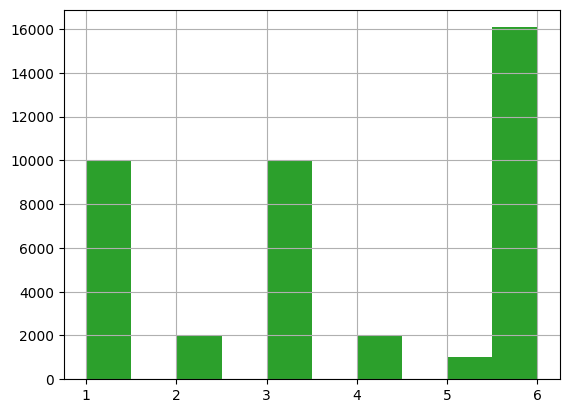

In [23]:
df.unbalanced_partition_key.hist()
plt.show()

In [20]:
test7_fg = fs.create_feature_group(name="test7_fg",
                                   version=1,
                                   primary_key=["ride_id"],
                                   partition_key=["unbalanced_partition_key"],
                                   description="test7_fg")   
test7_fg.save(df)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/123/jobs/named/test7_fg_1_offline_fg_backfill/executions


## 8) Create a feature group with multiple primary keys, some of them are duplicated.

In [24]:
df.head(3)

,ride_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,unbalanced_partition_key
0,1228,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,1
1,527,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,1
2,394,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,1


In [27]:
df["second_pk"] = df.ride_id + 100000

In [29]:
df["third_duplicated_pk"] = df.taxi_id + 1000000

In [32]:
df["third_duplicated_pk"].nunique()

200

In [33]:
df.shape

(41078, 13)

In [30]:
df.head(3)

,ride_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,unbalanced_partition_key,second_pk,third_duplicated_pk
0,1228,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,1,101228,2014000194
1,527,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,1,100527,2014000122
2,394,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,1,100394,2014000102


In [31]:
test8_fg = fs.create_feature_group(name="test8_fg",
                                   version=1,
                                   primary_key=["ride_id", "second_pk", "third_duplicated_pk"],
                                   description="test8_fg")   
test8_fg.save(df)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/123/jobs/named/test8_fg_1_offline_fg_backfill/executions


## 9) Read the feature group into a dataframe using the .read() method.

In [34]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='testing_featurestore')
fg = fs.get_feature_group('test8_fg', version=1)

Connected. Call `.close()` to terminate connection gracefully.


In [35]:
df_from_fg = fg.read(dataframe_type="pandas")

2022-05-26 22:39:45,149 INFO: USE `testing_featurestore`
2022-05-26 22:39:45,960 INFO: SELECT `fg0`.`ride_id` `ride_id`, `fg0`.`pickup_datetime` `pickup_datetime`, `fg0`.`dropoff_datetime` `dropoff_datetime`, `fg0`.`pickup_longitude` `pickup_longitude`, `fg0`.`pickup_latitude` `pickup_latitude`, `fg0`.`dropoff_longitude` `dropoff_longitude`, `fg0`.`dropoff_latitude` `dropoff_latitude`, `fg0`.`passenger_count` `passenger_count`, `fg0`.`taxi_id` `taxi_id`, `fg0`.`driver_id` `driver_id`, `fg0`.`unbalanced_partition_key` `unbalanced_partition_key`, `fg0`.`second_pk` `second_pk`, `fg0`.`third_duplicated_pk` `third_duplicated_pk`
FROM `testing_featurestore`.`test8_fg_1` `fg0`


In [36]:
df_from_fg.head(3)

,ride_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,unbalanced_partition_key,second_pk,third_duplicated_pk
0,40011,1578680220000,0,-73.908005,40.707993,-73.922620,40.689390,2,2013000075,2013000075,6,140011,2014000075
1,37955,1578639100000,0,-73.897354,40.721550,-73.924515,40.686980,2,2013000196,2013000196,6,137955,2014000196
2,14413,1578168260000,0,-73.689290,40.986350,-73.730590,40.933792,4,2013000053,2013000053,3,114413,2014000053


In [37]:
df_from_fg.shape

(41078, 13)

In [38]:
df_from_fg.ride_id.nunique()

41078

In [39]:
df_from_fg.third_duplicated_pk.nunique()

200

## 10) Create a feature group with different expectations.

In [41]:
from hsfs.rule import Rule

In [40]:
# Get all rule definitions available in Hopsworks
rules = connection.get_rules()
[print(rule.to_dict()) for rule in rules]

{'name': 'HAS_MAX', 'predicate': None, 'acceptedType': 'Fractional', 'featureType': 'Numerical', 'description': 'Assert on the max of a feature.'}
{'name': 'IS_CONTAINED_IN', 'predicate': 'LEGAL_VALUES', 'acceptedType': 'String', 'featureType': None, 'description': 'Assert that every non-null value of feature is contained in a set of predefined values.'}
{'name': 'IS_LESS_THAN', 'predicate': 'FEATURE', 'acceptedType': 'Fractional', 'featureType': None, 'description': 'Assert on feature A values being less that feature B.'}
{'name': 'IS_POSITIVE', 'predicate': None, 'acceptedType': 'Fractional', 'featureType': None, 'description': 'Assert on a feature containing non negative values.'}
{'name': 'HAS_DATATYPE', 'predicate': 'ACCEPTED_TYPE', 'acceptedType': 'String', 'featureType': None, 'description': 'Assert on the fraction of rows that conform to the given data type.'}
{'name': 'HAS_NUMBER_OF_DISTINCT_VALUES', 'predicate': None, 'acceptedType': 'Integral', 'featureType': None, 'descript

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [42]:
# Get a rule definition by name
is_positive = connection.get_rule("IS_POSITIVE")
print(is_positive.to_dict())

{'name': 'IS_POSITIVE', 'predicate': None, 'acceptedType': 'Fractional', 'featureType': None, 'description': 'Assert on a feature containing non negative values.'}


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41078 entries, 0 to 41077
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ride_id                   41078 non-null  int64  
 1   pickup_datetime           41078 non-null  object 
 2   dropoff_datetime          41078 non-null  int64  
 3   pickup_longitude          41078 non-null  float64
 4   pickup_latitude           41078 non-null  float64
 5   dropoff_longitude         41078 non-null  float64
 6   dropoff_latitude          41078 non-null  float64
 7   passenger_count           41078 non-null  int64  
 8   taxi_id                   41078 non-null  int64  
 9   driver_id                 41078 non-null  int64  
 10  unbalanced_partition_key  41078 non-null  int64  
 11  second_pk                 41078 non-null  int64  
 12  third_duplicated_pk       41078 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 5.4+ MB


In [44]:
expectation_passengers = fs.create_expectation("expectation_passengers",
                                           features=["passenger_count"], 
                                           description="expectation_passengers",
                                           rules=[Rule(name="IS_POSITIVE", level="ERROR", max=10)])
expectation_passengers.save()

In [46]:
test10_fg = fs.create_feature_group(name="test10_fg",
                                   version=1,
                                   primary_key=["ride_id"],
                                   description="test10_fg",
                                   expectations= [expectation_passengers])   
test10_fg.save(df)


Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/123/jobs/named/test10_fg_1_offline_fg_backfill/executions


In [48]:
help(fs.create_feature_group)

Help on method create_feature_group in module hsfs.feature_store:

create_feature_group(name: str, version: Union[int, NoneType] = None, description: Union[str, NoneType] = '', online_enabled: Union[bool, NoneType] = False, time_travel_format: Union[str, NoneType] = 'HUDI', partition_key: Union[List[str], NoneType] = [], primary_key: Union[List[str], NoneType] = [], hudi_precombine_key: Union[str, NoneType] = None, features: Union[List[hsfs.feature.Feature], NoneType] = [], statistics_config: Union[hsfs.statistics_config.StatisticsConfig, bool, dict, NoneType] = None, validation_type: Union[str, NoneType] = 'NONE', expectations: Union[List[hsfs.expectation.Expectation], NoneType] = [], event_time: Union[str, NoneType] = None, stream: Union[bool, NoneType] = False) method of hsfs.feature_store.FeatureStore instance
    Create a feature group metadata object.
    
    !!! note "Lazy"
        This method is lazy and does not persist any metadata or feature data in the
        feature stor

In [51]:
test10_fg = fs.create_feature_group(name="test10_1_fg",
                                   version=1,
                                   primary_key=["ride_id"],
                                   description="test10_fg",
                                   validation_type="ALL",
                                   expectations= [expectation_passengers])   
test10_fg.save(df)


RestAPIError: Metadata operation error: (url: https://hopsworks.glassfish.service.consul:8182/hopsworks-api/api/project/123/featurestores/71/featuregroups). Server response: 
HTTP code: 400, HTTP reason: Bad Request, error code: 270183, error msg: Rule is not supported., user msg: For stream featuregroups validattion rules are not supported

## 11) Save new version of feature group.

In [8]:
df.head(3)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102


In [10]:
df11 = df.drop(columns=['is_start', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

In [11]:
df11

,ride_id,pickup_datetime,passenger_count,taxi_id,driver_id
0,1228,1577904560000,3,2013000194,2013000194
1,527,1577890540000,3,2013000122,2013000122
2,394,1577887880000,3,2013000102,2013000102
3,1366,1577907320000,3,2013000059,2013000059
4,1085,1577901700000,3,2013000064,2013000064
...,...,...,...,...,...
41073,40836,1578696720000,2,2013000033,2013000033
41074,40639,1578692780000,2,2013000162,2013000162
41075,40909,1578698180000,2,2013000098,2013000098
41076,40873,1578697460000,2,2013000178,2013000178


In [12]:
df11.pickup_datetime = df11.pickup_datetime.astype(int)

In [13]:
# saving new version of previously created FG

test5_fg = fs.create_feature_group(name="test5_fg",
                                   version=2,
                                   primary_key=["ride_id"],   
                                   description="test5_fg",
                                   event_time=["pickup_datetime"])   
test5_fg.save(df11)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/123/jobs/named/test5_fg_2_offline_fg_backfill/executions


## 12) Read different versions of the feature group.

In [14]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='testing_featurestore')
fg = fs.get_feature_group('test5_fg', version=2)

Connected. Call `.close()` to terminate connection gracefully.


In [15]:
df_from_fg = fg.read(dataframe_type="pandas")

2022-05-29 10:57:44,611 INFO: USE `testing_featurestore`
2022-05-29 10:57:45,459 INFO: SELECT `fg0`.`ride_id` `ride_id`, `fg0`.`pickup_datetime` `pickup_datetime`, `fg0`.`passenger_count` `passenger_count`, `fg0`.`taxi_id` `taxi_id`, `fg0`.`driver_id` `driver_id`
FROM `testing_featurestore`.`test5_fg_2` `fg0`


In [16]:
df_from_fg.head(3)

,ride_id,pickup_datetime,passenger_count,taxi_id,driver_id
0,30400,1578488000000,3,2013000128,2013000128
1,15067,1578181340000,3,2013000102,2013000102
2,6993,1578019860000,2,2013000125,2013000125


In [18]:
df_from_fg.shape

(41078, 5)

In [20]:
df_from_fg.ride_id.nunique(), df_from_fg.pickup_datetime.nunique()

(41078, 41078)

## 13) Read feature group not specifying version.

In [21]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='testing_featurestore')
fg = fs.get_feature_group('test5_fg')

Connected. Call `.close()` to terminate connection gracefully.


## 14) Read the feature group version which does not exist.

In [22]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='testing_featurestore')
fg = fs.get_feature_group('test5_fg', version=5)

Connected. Call `.close()` to terminate connection gracefully.


RestAPIError: Metadata operation error: (url: https://hopsworks.glassfish.service.consul:8182/hopsworks-api/api/project/123/featurestores/71/featuregroups/test5_fg). Server response: 
HTTP code: 404, HTTP reason: Not Found, error code: 270009, error msg: Featuregroup wasn't found., user msg: feature group name: test5_fg feature group version: 5